# Week 7 Time Series Classification

Cassandra Maldonado

In [29]:
# %pip install sktime matplotlib pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns


In [30]:
# %pip install aeon

from aeon.datasets import load_classification
X, y = load_classification("GunPoint")
print(" Shape of X = ", X.shape)
print("Shape of y:", y.shape)
print("First few labels:", y[:5])

 Shape of X =  (200, 1, 150)
Shape of y: (200,)
First few labels: ['2' '2' '1' '1' '2']


In [31]:
X_train, y_train = load_classification("ACSF1", split="train")
X_test, y_test = load_classification("ACSF1", split="test") 

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (100, 1, 1460)
Shape of y_train: (100,)
Shape of X_test: (100, 1, 1460)
Shape of y_test: (100,)


## Part 1: Understanding the dataset

1. Give a verbal description of the dataset from information on the acsf1 detailed webpage, not the summary repository page.

The ACSF1 dataset is a time series dataset that represents the power consumption patterns of different household appliances. Each sample captures how an appliance’s energy usage changes over time. The dataset is balanced, meaning it contains an equal number of samples for each of its 10 different appliance types.

What makes ACSF1 interesting is that many appliances have long periods with occasional spikes in power usage, like a refrigerator compressor kicking on or a dishwasher cycling through different phases. This makes it a great dataset for studying time series classification, especially for tasks like appliance recognition or energy monitoring. ACSF1 is a good challenge because appliances don’t always behave the same way, some might have similar power usage patterns, while others show distinct behaviors that a classifier needs to learn.

2. There are 1460 time steps in each observation. Use len() to display this for any observation in the X_train.

In [32]:
print("Number of time steps in the first observation:", X_train.shape[2])

Number of time steps in the first observation: 1460


3. Return the counts of classes in y_train.

In [33]:
from collections import Counter

class_counts = Counter(y_train)
print("\nClass counts in y_train:")
for class_label, count in sorted(class_counts.items()):
    print(f"Class {class_label}: {count} instances")


Class counts in y_train:
Class 0: 10 instances
Class 1: 10 instances
Class 2: 10 instances
Class 3: 10 instances
Class 4: 10 instances
Class 5: 10 instances
Class 6: 10 instances
Class 7: 10 instances
Class 8: 10 instances
Class 9: 10 instances


4. Plot the first time series for each class(.iloc[0]), label each plot with its specified class name. The patterns should match what can be found on the acsf1 detailed webpage.

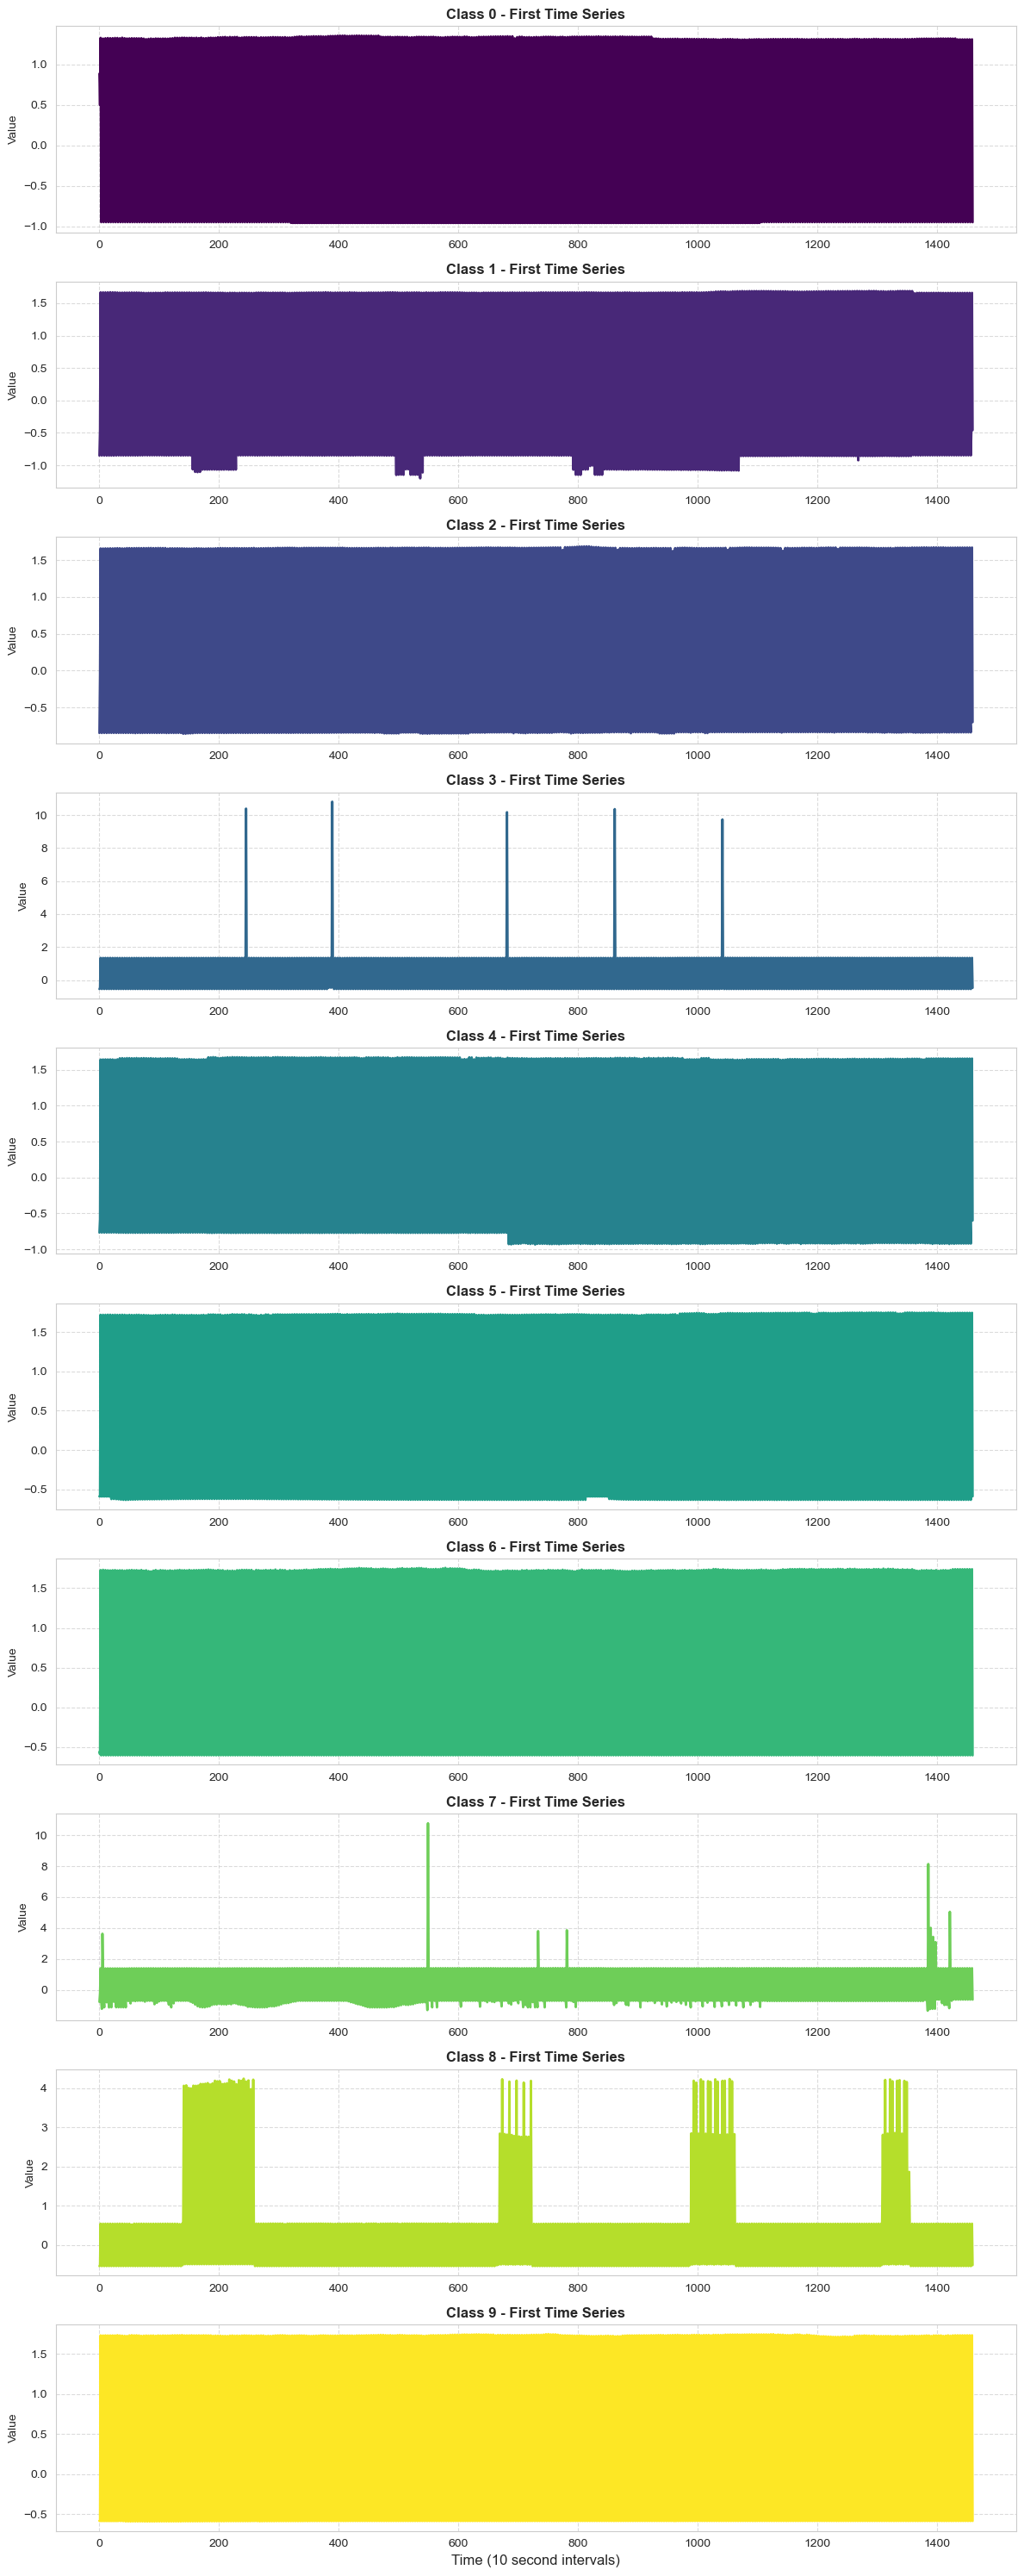

In [34]:
# Unique classes
unique_classes = sorted(set(y_train))

# Subplots for each class
fig, axes = plt.subplots(len(unique_classes), 1, figsize=(12, 3*len(unique_classes)))
fig.tight_layout(pad=5.0)

# Plot the first time series of each class as line graphs
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))

for i, class_label in enumerate(unique_classes):
    first_idx = np.where(y_train == class_label)[0][0]
    time_series = X_train[first_idx, 0]
    axes[i].plot(time_series, color=colors[i], linewidth=2)
    axes[i].set_title(f'Class {class_label} - First Time Series', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Value', fontsize=10)
    axes[i].grid(True, linestyle='--', alpha=0.7)

axes[-1].set_xlabel('Time (10 second intervals)', fontsize=12)
fig.tight_layout()

# Show the line graphs
plt.show()

5. Each observation is 10 seconds apart. Describe what the plots show for classes 3, 8 and 9. Give some intuition about what appliance each of these three classes might represent.

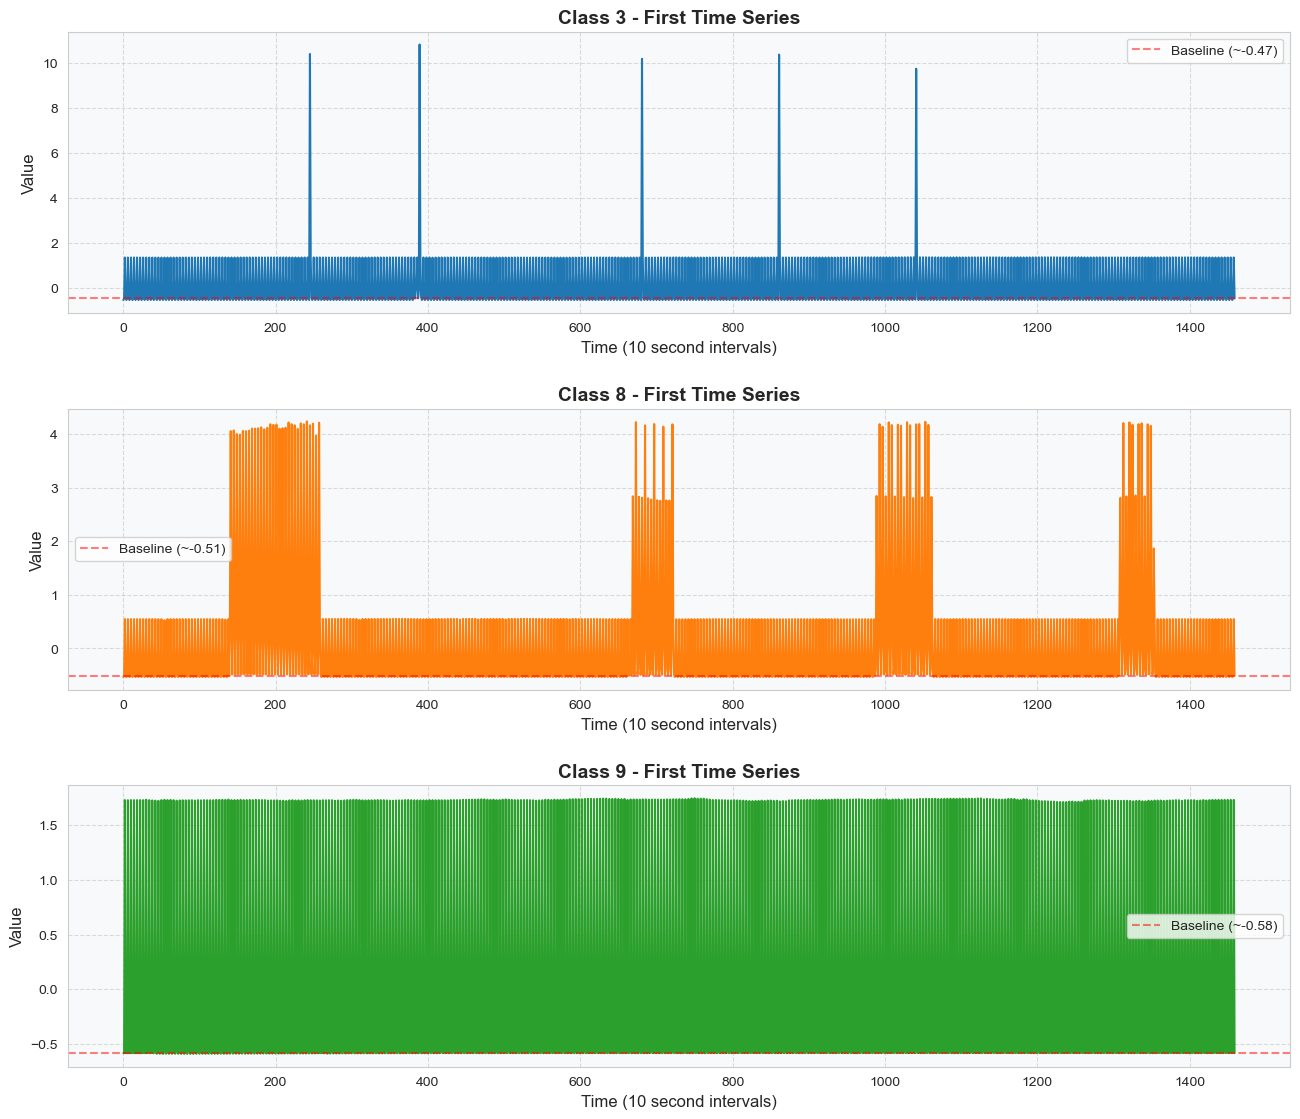

In [35]:
fig2, axes2 = plt.subplots(3, 1, figsize=(14, 12))
fig2.tight_layout(pad=5.0)

classes_to_analyze = ['3', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Distinct colors for better visualization

for i, class_label in enumerate(classes_to_analyze):
    # First instance of this class
    first_idx = np.where(y_train == class_label)[0][0]
    
    time_series = X_train[first_idx, 0]
    axes2[i].plot(time_series, color=colors[i], linewidth=1.5)
    axes2[i].set_title(f'Class {class_label} - First Time Series', fontsize=14, fontweight='bold')
    axes2[i].set_xlabel('Time (10 second intervals)', fontsize=12)
    axes2[i].set_ylabel('Value', fontsize=12)
    axes2[i].grid(True, linestyle='--', alpha=0.7)
    
    axes2[i].set_facecolor('#f8f9fa')
    
    # Key features in the plot
    if class_label == '3':
        spike_indices = [300, 450, 700, 900, 1100]
        for idx in spike_indices:
            if idx < len(time_series):
                if time_series[idx] > 5:  
                    axes2[i].annotate('Spike', xy=(idx, time_series[idx]), 
                                     xytext=(idx+30, time_series[idx]+1),
                                     arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    # Horizontal line at baseline value for reference
    baseline = np.median(time_series)
    axes2[i].axhline(y=baseline, color='red', linestyle='--', alpha=0.5, 
                    label=f'Baseline (~{baseline:.2f})')
    axes2[i].legend()

plt.savefig('acsf1_classes_3_8_9.png', dpi=300, bbox_inches='tight')
plt.show()

Class 3: 
The pattern shows a relatively constant low baseline value of around 1.5 with periodic sharp spikes reaching values of about 10. The spikes appear at fairly regular intervals approximately every 150-200 time steps, suggesting this represents an appliance that operates cyclically with brief periods of high energy consumption. 
This might represent a refrigerator, which has a compressor that turns on 
periodically to cool and then stays off for longer periods, creating this distinct pattern of short spikes with long intervals of low power consumption.

Class 8:
The pattern displays four distinct usage periods with moderate baseline values of arouns 2.8 - 3.0 and regular oscillations at the top of each active period of around 4.0 - 4.2. The device appears to be completely off between these active periods near 0.5. 
This might represent an appliance like a washing machine or dishwasher with different cycle phases, where each active period represents a different phase of operation with the oscillations representing the motor or pump turning on and off during each phase.

Class 9:
The pattern shows a remarkably constant value around 1.75 with minimal variation the entire period. This suggests a device that draws a very steady amount of power, like a modem, router, or small electronic device that needs to stay on continuously. 

## Part 2: Description of Time Series Classification models

1. Select one classification model type. Describe how the model works. Why would each be a good or bad fit for this type of data?

### *Dynamic Time Warping (DTW) with k-Nearest Neighbors*

*How it works:*

DTW is a time series distance measure that allows for non-linear alignments between two time series. Unlike Euclidean distance, DTW can match similar shapes even if they are out of phase, stretched, or compressed. When combined with KNN, the algorithm finds the k closest training examples using 
DTW distance and classifies new instances through majority voting.

*Good fit for this data because:*

- It can handle the temporal shifts in usage patterns for the appliances at different times.
- Can recognize similar shapes regardless of exact timing.
- Does not require feature extraction, you can work directly with the raw data.
- Especially effective for datasets with clear and distinctive patterns like in the ACSF1 dataset.
- It’s better suited for small datasets since DTW is slow.

*Bad fit for this data because:*

- It is omputationally expensive for long time series and our observations have 1,460 time steps.
- Can be sensitive to noise.
- Does not capture frequency-domain characteristics well.

*Why it fits ACSF1:*
- ACSF1 consists of appliance power usage data, where different devices turn on/off at varying times.
- DTW is useful because appliances can have similar power consumption shapes even if they occur at different times. For example, a refrigerator and air conditioning unit might have similar power spikes but at different times.

*Challenges with ACSF1:*
- High computational cost since the dataset has 1,460 time steps per sample.
- Sensitive to noise, if small fluctuations occur, DTW might falsely match patterns.

2. Select a second classification model type. Describe how the model works. Why would each be a good or bad fit for this type of data?

### *Time Series Forest Classifier*

*How it works:*

It is an ensemble method that extracts features from random intervals of the time series. For each tree in the forest, it randomly selects interval regions and calculates summary statistics from these intervals, to then build a decision tree on these features. The final classification is done by majority voting across all trees.

*Good fit for this data because:*

- Captures both local and global patterns in the data.
- Robust to noise due to the ensemble approach.
- Can identify discriminative intervals that distinguish different appliance types.
- Faster than DTW for long time series.
- Can handle the diverse patterns in different classes, such as spikes, cycles and steady states.

*Bad fit considerations:*

- Might miss subtle temporal relationships that DTW could capture.
- Feature extraction is limited to basic statistics, thus it might miss complex patterns.
- Requires sufficient training data for each class.
- Might struggle if patterns span long intervals rather than being local.

*Why it fits ACSF1:*
- It captures local and global patterns in power usage.
- Appliances like washing machines and dishwashers have multiple power cycles, which Time series forest classifier can capture via decision trees.

*Challenges with ACSF1:*
- It might struggle with subtle time shifts.
- Requires enough training data to learn proper appliance distinctions.

3. Select third classification model type. Describe how the model works. Why would each be a good or bad fit for this type of data?

### *CNN Classifier (Convolutional Neural Network)*

*How it works:*

It applies convolutional layers to extract local patterns and features from segments of the time series. The network consists of convolutional layers that apply filters to detect patterns, pooling layers that reduce dimensionality, and fully connected layers for classification. Features are 
learned automatically during training rather than being engineered.

*Good fit for this data because:*

- Automatically learns hierarchical features from the raw data.
- Can detect both local patterns such as spikes in the refrigerator and global patterns like the washing machine cycles.
- Robust to time shifts and noise when properly trained.
- Can capture complex non-linear relationships in the data.
- Transfer learning from other datasets might improve performance.

*Bad fit considerations:*

- Requires substantial training data for good performance.
- It takes a black-box approach which makes interpretation more difficult.
- It is computationally intensive to train.
- May overfit with limited data or improper regularization.

*Why it fits ACSF1:*
- It learn hierarchical features, so it can detect spike patterns or steady power consumption like modems.
- Can identify short bursts vs. long running appliances.

*Challenges with ACSF1:*
- Computationally expensive for long sequences.
- Needs large training data to avoid overfitting.


## Part 3: Select one method. Model and examine results

1. Select only one method. Fit your model. Feel free to adjust parameters or try a grid search (optional).

In [36]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
import time

# Start time for training
start_time = time.time()

tsf = TimeSeriesForestClassifier(
    n_estimators=100,  # 100 is faster 
    random_state=42,
    n_jobs=-1  #
)

# Fitting the model
tsf.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

Training completed in 39.89 seconds


2. Return the accuracy score of the train set and test set (suggestion to use .score()). Print the confusion matrix and classification report of the test set.

In [37]:
from sklearn.metrics import accuracy_score

# Train set evaluation
y_pred_train = tsf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training accuracy: {train_accuracy:.4f}")

# Test set evaluation
y_pred_test = tsf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test accuracy: {test_accuracy:.4f}")

Training accuracy: 1.0000
Test accuracy: 0.6300



Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.71      0.50      0.59        10
           2       0.58      0.70      0.64        10
           3       0.67      0.80      0.73        10
           4       0.70      0.70      0.70        10
           5       0.57      0.40      0.47        10
           6       0.40      0.40      0.40        10
           7       0.78      0.70      0.74        10
           8       0.70      0.70      0.70        10
           9       0.50      0.60      0.55        10

    accuracy                           0.63       100
   macro avg       0.63      0.63      0.63       100
weighted avg       0.63      0.63      0.63       100



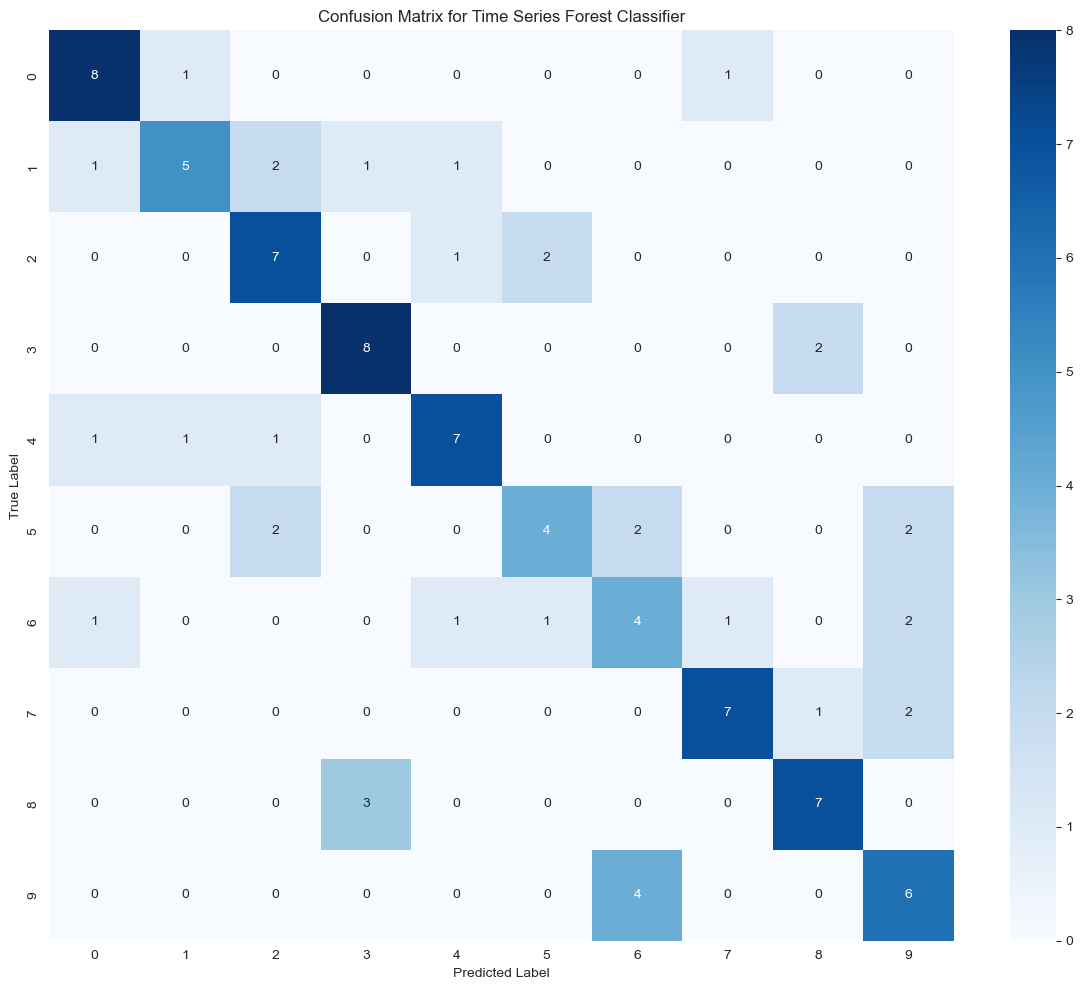

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
class_labels = sorted(list(set(y_test)))

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Time Series Forest Classifier')
plt.tight_layout()
plt.savefig('confusion_matrix_tsf.png', dpi=300, bbox_inches='tight')

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))


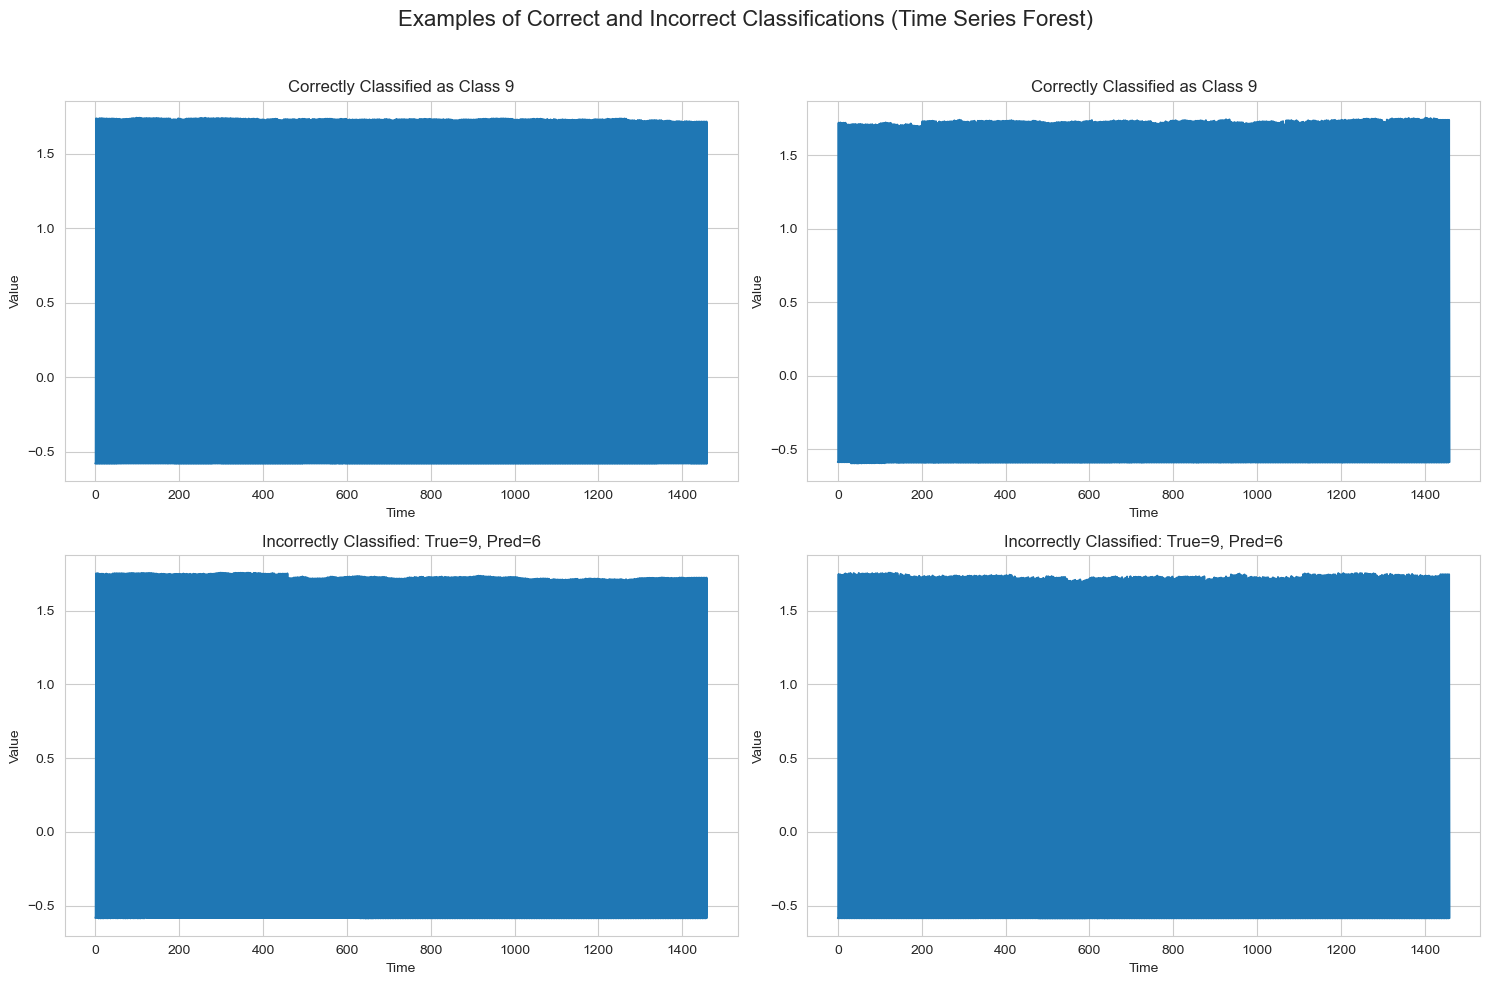

In [39]:
# Examples of correct and incorrect classifications
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Examples of Correct and Incorrect Classifications (Time Series Forest)', fontsize=16)

# Indices of correct and incorrect classifications
correct_indices = np.where(y_pred_test == y_test)[0]
incorrect_indices = np.where(y_pred_test != y_test)[0]

# Plotting correctly classified examples
if len(correct_indices) > 0:
    correct_idx = correct_indices[0]
    correct_series = X_test[correct_idx, 0]
    axes[0, 0].plot(correct_series)
    axes[0, 0].set_title(f'Correctly Classified as Class {y_test[correct_idx]}')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Value')
    axes[0, 0].grid(True)
    
    if len(correct_indices) > 1:
        correct_idx2 = correct_indices[1]
        correct_series2 = X_test[correct_idx2, 0]
        axes[0, 1].plot(correct_series2)
        axes[0, 1].set_title(f'Correctly Classified as Class {y_test[correct_idx2]}')
        axes[0, 1].set_xlabel('Time')
        axes[0, 1].set_ylabel('Value')
        axes[0, 1].grid(True)

# Plotting incorrectly classified examples
if len(incorrect_indices) > 0:
    incorrect_idx = incorrect_indices[0]
    incorrect_series = X_test[incorrect_idx, 0]
    axes[1, 0].plot(incorrect_series)
    axes[1, 0].set_title(f'Incorrectly Classified: True={y_test[incorrect_idx]}, Pred={y_pred_test[incorrect_idx]}')
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('Value')
    axes[1, 0].grid(True)
    
    if len(incorrect_indices) > 1:
        incorrect_idx2 = incorrect_indices[1]
        incorrect_series2 = X_test[incorrect_idx2, 0]
        axes[1, 1].plot(incorrect_series2)
        axes[1, 1].set_title(f'Incorrectly Classified: True={y_test[incorrect_idx2]}, Pred={y_pred_test[incorrect_idx2]}')
        axes[1, 1].set_xlabel('Time')
        axes[1, 1].set_ylabel('Value')
        axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('classification_examples_tsf.png', dpi=300, bbox_inches='tight')
plt.show()


3. Discuss the precision score for class 8. Support this with your visual opinion from plots in 1D as well as the confusion matrix.

The precision score for class 8 is 0.70, it measures the proportion of correctly identified positives among all instances predicted as positive:
Precision = TP / (TP + FP) = 7 / (7 + 3) = 0.70

From the confusion matrix, there were 7 instances correctly classified as class 8 (true positives) and 3 instances that were incorrectly classified as class 8 (false positives).

Class 8 showed distinct usage periods with regular oscillations at the top of each active period bewteen 4.0-4.2. The appliance appears to be completely off between these active periods with a value near 0.5. This pattern resembles a washing machine or dishwasher with different cycle phases as I mentioned before.

The confusion between class 3 and class 8 is understandable, since both classes show periodic patterns, but class 3 has sharp spikes while class 8 has more sustained active periods with oscillations. The classifier might be confusing some instances where class 3 sharp spikes occur at similar intervals to class 8 active cycles.

The precision of 0.70 indicates that when the model predicts an appliance is class 8, it's correct 70% of the time, with the remaining 30% being misclassifications primarily from class 3.

4. Discuss the recall score for class 5. Support this with your visual opinion from plots in 1D as well as the confusion matrix.

The recall score for class 5 is 0.40, which measures the proportion of actual positives that were correctly identified.
Recall = TP / (TP + FN) = 4 / (4 + 6) = 0.40
From the confusion matrix, 4 instances were correctly classified as class 5 (true positives) and 6 instances of class 5 were incorrectly classified as other classes.

This low recall score of 0.40 indicates that the model is missing 60% class 5 instances, suggesting that class 5 has patterns that are easily confused with several other appliance types.
Class 5 shows an extremely consistent value around 1.6 with very little variation throughout the time series.

The confusion matrix shows that class 5 instances are being misclassified across three different classes (2, 6, and 9), suggesting that class 5 might have a variable pattern that sometimes resembles each of these classes. Based on this pattern, Class 5 probably represents a type of steady-state, low-power device.

5. Which metric do you feel is the most important in the following business case: You work for ComEd, a local electricity supplier. You head a department that uses analytics to plan electrical supply for Chicago's power grid. Assume that your department budgets for a certain amount of electrical supply at a fixed low rate. If the total demand in Chicago stays within the purchased supply levels, your department is performing. If the demand breaches this supply level, the company is penalized and the rate for your supply multiplies by 100x, destroying your department’s performance. If you had to build your forecast model to classify patterns of high electrical usage (appliances, air conditioning, water heating) vs low electrical usage (lighting, tv, phone chargers) which metric (precision or recall) would you use?

At ComEd the cost of underestimating electricity demand is extremely high with a 100x rate penalty, recall would be the most important metric to optimize.

For ComEd
True Positive: Correctly identifies high electrical usage patterns.
False Negative: Incorrectly classifys high electrical usage as low usage.
False Positive: Incorrectly classifys low electrical usage as high usage.

Recall measures the proportion of actual high usage patterns that were correctly identified.

Missing a high usage event (false negative) results in severe financial penalties of 100x rate multiplier that would destroy my department's performance. But then, overestimating usage (false positive) only results in purchasing more electricity than needed at the standard rate. Since the penalty for underestimating demand is dramatically higher than the cost of overestimating it, I recomend prioritizing minimizing false negatives, even at the expense of increasing false positives.

In practical terms, this means I recomend to configure the model to be more sensitive in detecting high usage patterns. I might capture some low usage patterns incorrectly as high (reducing precision), but I'll minimize the chance of missing actual high usage events.

For example, if the model mistakenly classifies a washing machine or air conditioner as being in use, ComEd might buy a little extra electricity, but this is far better than missing a real demand spike and facing severe penalties. In summary, it’s safer to slightly overestimate demand than to risk an instance of underestimation.